In [1]:
## Dependencies 
import numpy as np
import pandas as pd
#from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

In [2]:
## Import the embeddings
path = 'data/embeddings/embeddings.npy'
emb = np.load(path)
print("Embeddings are of the shape {}".format(emb.shape))
print("Column {} is the labels corresponding to each embedding".format(emb.shape[1]))

Embeddings are of the shape (70000, 197)
Column 197 is the labels corresponding to each embedding


In [3]:
## splitting into test and train embeddings
idx = np.random.permutation(70000)
emb_train = emb[idx[:60000]]
emb_test = emb[idx[60000:]]

In [102]:
#a = np.linalg.norm((emb_test[1][:-1].reshape(1,-1).repeat(6, axis=0) - emb_train[:6,:-1]), axis=1)

array([[ 0.25627127,  0.07363573,  0.07376003, ...,  0.9175843 ,
        -0.4824415 , -0.4824415 ],
       [-0.13509664, -0.18382551, -0.18797952, ...,  0.56219673,
         0.34643215,  0.56165206],
       [ 0.22375783,  0.07746761,  0.07573828, ..., -0.30065253,
        -0.13048995, -0.4824415 ],
       ...,
       [-0.13509664, -0.18382551, -0.15929711, ...,  0.65430033,
         0.3459939 ,  0.56176496],
       [ 0.22375783,  0.04594029, -0.20658448, ..., -0.44862086,
        -0.4824415 , -0.4824415 ],
       [ 0.22375783,  0.07746761,  0.06765181, ...,  0.97849184,
        -0.4824415 , -0.4824415 ]], dtype=float32)

/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [94]:
a = [(a[i],emb_train[:6,-1][i]) for i in range(6)]
a.sort()

[(8.551623, 7.0),
 (8.954226, 8.0),
 (9.094346, 8.0),
 (9.630037, 1.0),
 (9.908268, 2.0),
 (10.909585, 0.0)]

/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [99]:
temp = a[:3]
b = [digit[1] for digit in temp]
c = [b.count(i) for i in b]
b[c.index(max(c))]

8.0

/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [ ]:
"""
## To-Do
- Try the same on the only the MNIST datasets

- Decide on k values
- Calculate distance of each test instance with database and append to list
- Sort in descending order
- Pick the first 'k' values and assign test emb to majority clas
- Calculate the error

"""
emb_train = emb[idx[:60000]]
emb_test = emb[idx[60000:]]
#emb_test = emb_train
k_test = 100
predictions = dict()

for k in range(1,k_test+1) : predictions[k] = list()

for test_inst in emb_test:

    ## Calculate the distance of each test instance from train instances 
    test_inst = test_inst[:-1]
    test_inst = test_inst.reshape(1,-1)
    test_inst = test_inst.repeat(60000, axis=0)
    temp_dist = np.linalg.norm((test_inst - emb_train[:,:-1]), axis=1)

    ## Store distance and respective labels in tuples in a list
    temp_dist_idx = [(temp_dist[i],emb_train[:,-1][i]) for i in range(len(emb_train))]
    temp_dist_idx.sort()

    for k in range(1,k_test+1):
    
        ## Choose first k elements from sorted list 'temp_dist_idx'
        temp_first_k = temp_dist_idx[:k]
        temp_labels = [digit[1] for digit in temp_first_k]

        ## Pick label that has majority count and append to prediction list
        temp_list = [temp_labels.count(i) for i in temp_labels]
        predictions[k].append(temp_labels[temp_list.index(max(temp_list))])

name = "predictions_knn_new"
with open(name + '.pkl', 'wb') as f:
    pickle.dump(predictions, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
## Calculate accuracy 
accuracy = list()
for k in range(1,k_test+1):
    sim_pred = sum(predictions[k] == emb_test[:,-1])
    accuracy.append((sim_pred/len(emb_test),k))

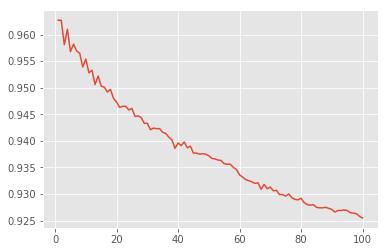

In [11]:
## Plotting accuracy (y_axis) vs K value (x_axis) curve
acc_k = [val[1] for val in accuracy]
acc_val = [val[0] for val in accuracy]

plt.plot(acc_k, acc_val)
plt.show()

In [46]:
name = "predictions_knn"
with open(name + '.pkl', 'wb') as f:
    pickle.dump(predictions, f, pickle.HIGHEST_PROTOCOL)
    
"""
with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f) """

/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
